In [241]:
import pandahouse
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

rng = np.random.default_rng()

### AA test

In [212]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20241020',
'user':'student',
'password':'dpo_python_2020'
}

In [213]:
q = """
select 
   user_id,
   exp_group,
   sum(action='view') as views,
   sum(action='like') as likes,
   likes/views as ctr 
from simulator_20241020.feed_actions
where toDate(time) between '2024-12-27' and '2025-01-02' and exp_group in (2,3)
group by user_id, exp_group
"""

In [214]:
df=pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,views,likes,ctr
0,78186,2,74,16,0.216216
1,115383,3,28,5,0.178571
2,10326,3,13,2,0.153846
3,131473,2,65,8,0.123077
4,36785,3,29,6,0.206897


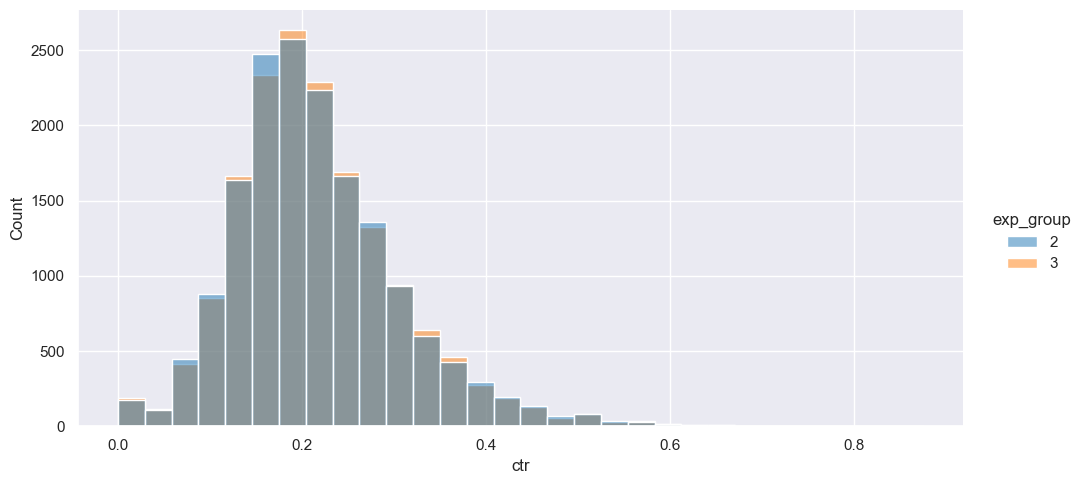

In [215]:
sns.displot(data=df, x='ctr', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [216]:
samples = 500
n_tests = 10000
p_values=[]
for i in range(n_tests):
    group_a1=df[df['exp_group']==2].ctr.sample(samples, replace=True)
    group_a2=df[df['exp_group']==3].ctr.sample(samples, replace=True)
    p_value=ttest_ind(group_a1,group_a2, equal_var=False)[1]
    p_values.append(p_value)

<Axes: ylabel='Count'>

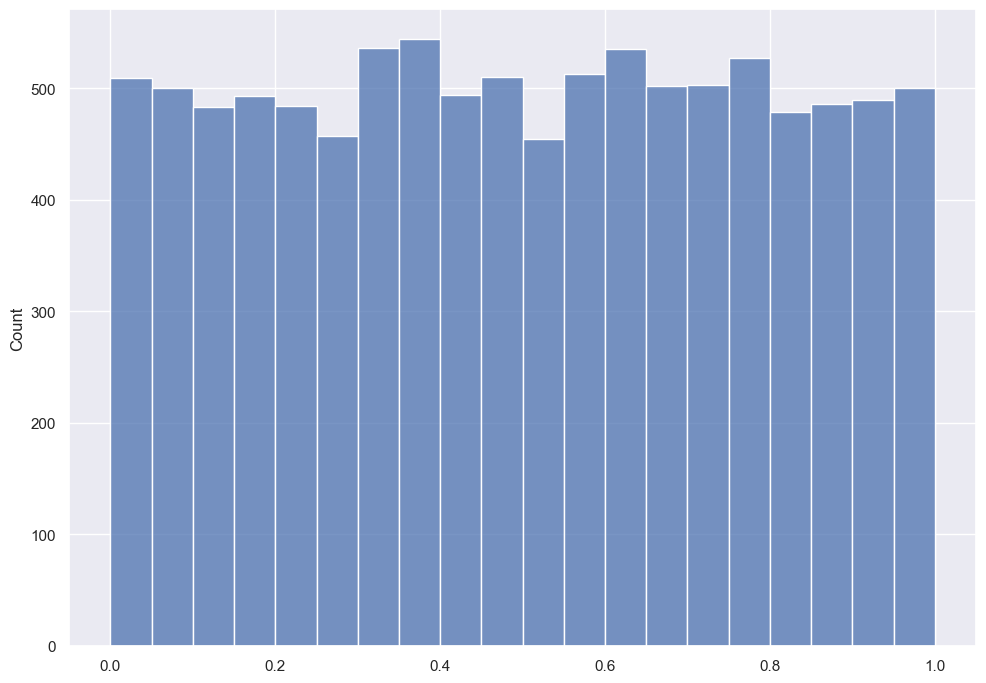

In [217]:
sns.histplot(p_values,bins=20,  kde=False)

In [218]:
sum(np.array(p_values) < 0.05) / n_tests

0.0509

The distribution of the resulting p-values is approximately uniform.The proportion of p-values below the significance threshold is approximately 0.046.his is approximately what
was expected. This means that the splitting system works correctly

### AB test

There will be an investigation of data on users who participated in A/B testing, which took place from 2025-01-03  to 2025-01-09, inclusive. Groups 2 and 1 were involved in the experiment.
**Group 2** used one of the new post recommendation algorithms (), while **group 1** was used as a control. The main hypothesis is that the new algorithm in group 2 will lead to an increase in CTR.

In [219]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250120',
'user':'student',
'password':'dpo_python_2020'
}

In [220]:
q = """
select 
   user_id,
   exp_group,
   sum(action='like') as likes,
   sum(action='view') as views,
   sum(action='like')/sum(action='view') as ctr 
from simulator_20250120.feed_actions 
where toDate(time) between '2025-01-03' and '2025-01-09' and exp_group in (1,2)
group by user_id, exp_group
"""

In [221]:
df=pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,39,141,0.276596
4,18392,1,7,32,0.218750


In [222]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [223]:
df.groupby('exp_group').ctr.mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

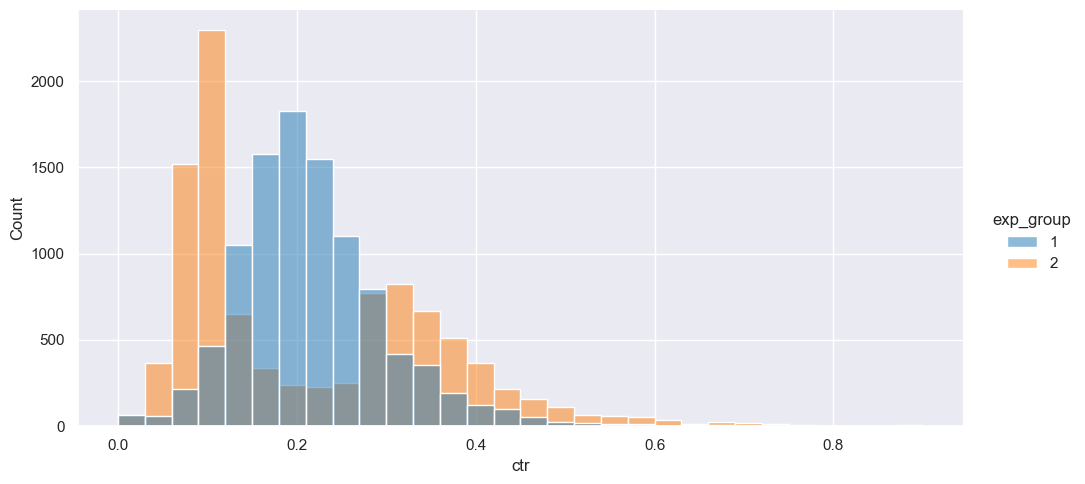

In [224]:
sns.displot(data=df, x='ctr', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [225]:
# H0 Hypothesis: P(A>B)=P(B>A)
print(stats.mannwhitneyu(df[df['exp_group']==1].ctr, df[df['exp_group']==2].ctr))

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)


There is a statistically significant difference in CTR between experimental groups 1 and 2.
The bimodality of the distribution tells us that there is a group of users who have been positively affected by the new algorithm and a group of users who have been negatively affected by it.For these reasons, the new algorithm should not be rolled out to all users.

In [226]:
print(ttest_ind(df[df['exp_group']==1].ctr, df[df['exp_group']==2].ctr, equal_var=False))

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)


Due to t-test is mean-sensitive, it cannot be applied to such highly skewed data. As a result, the t-test returns an incorrect result (2 type error, false negative, is the incorrect failure to reject a false null hypothesis)

### T-test on smoothed CTR

In [227]:
# get smothed ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [208]:
global_ctr_1= df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2= df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

In [231]:
group_1=df[df.exp_group == 1].copy()
group_2=df[df.exp_group == 2].copy()

In [237]:
group_1['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, alpha=5), axis=1)
group_2['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, alpha=5), axis=1)

In [238]:
group_1.head()

,user_id,exp_group,likes,views,ctr,smoothed_ctr
0,109963,1,3,15,0.200000,0.202401
1,26117,1,32,141,0.226950,0.226356
2,138232,1,18,73,0.246575,0.244205
3,26295,1,39,141,0.276596,0.274302
4,18392,1,7,32,0.218750,0.217514


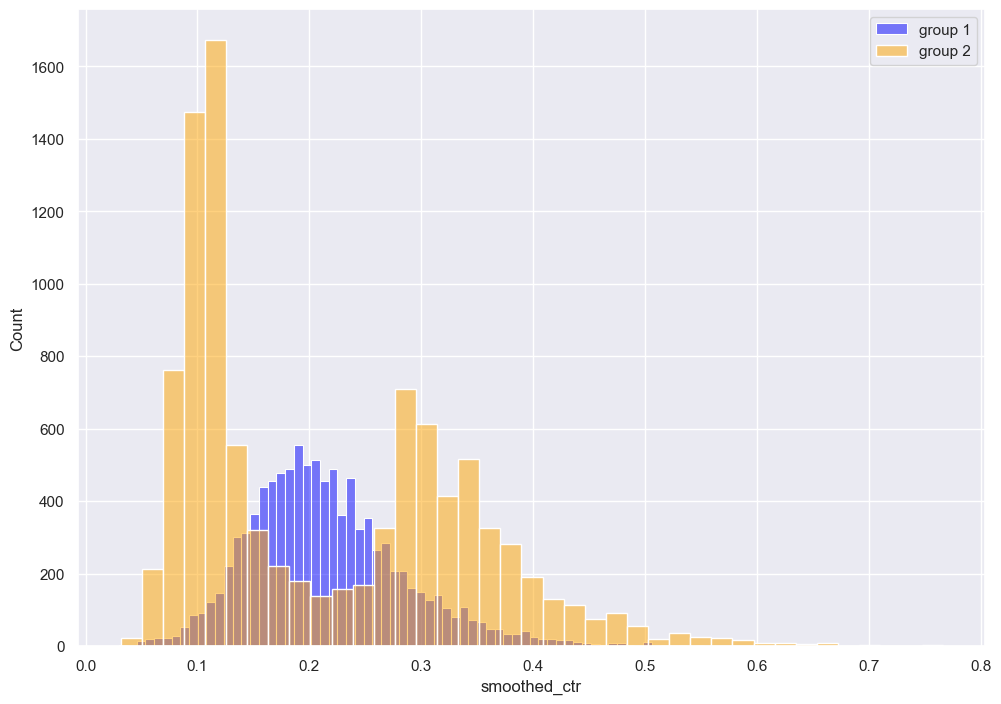

In [245]:
sns.histplot(group_1.smoothed_ctr, color='blue',alpha=0.5, label='group 1')
sns.histplot(group_2.smoothed_ctr, color='orange', alpha=0.5, label='group 2')
plt.legend()


In [246]:
# T-test on smoothed CTR
print(ttest_ind(group_1.smoothed_ctr, group_2.smoothed_ctr, equal_var=False))

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)


## A/B test on linearized CTR 


Hypothesis testing on linearized CTR. **Group 2** used one of the new post recommendation algorithms (), while **group 1** was used as a control. The main hypothesis is that the new algorithm in group 2 will lead to an increase in CTR.

In [ ]:
q = """
select 
   user_id,
   exp_group,
   sum(action='like') as likes,
   sum(action='view') as views,
   sum(action='like')/sum(action='view') as ctr 
from simulator_20250120.feed_actions 
where toDate(time) between '2025-01-03' and '2025-01-09' and exp_group in (1,2)
group by user_id, exp_group
"""

df=pandahouse.read_clickhouse(q, connection=connection)

In [ ]:
df['ctr_control']=df[df['exp_group']==1].likes.sum()/ df[df['exp_group']==1].views.sum()
df['linearized_likes']=df.likes-df.ctr_control*df.views

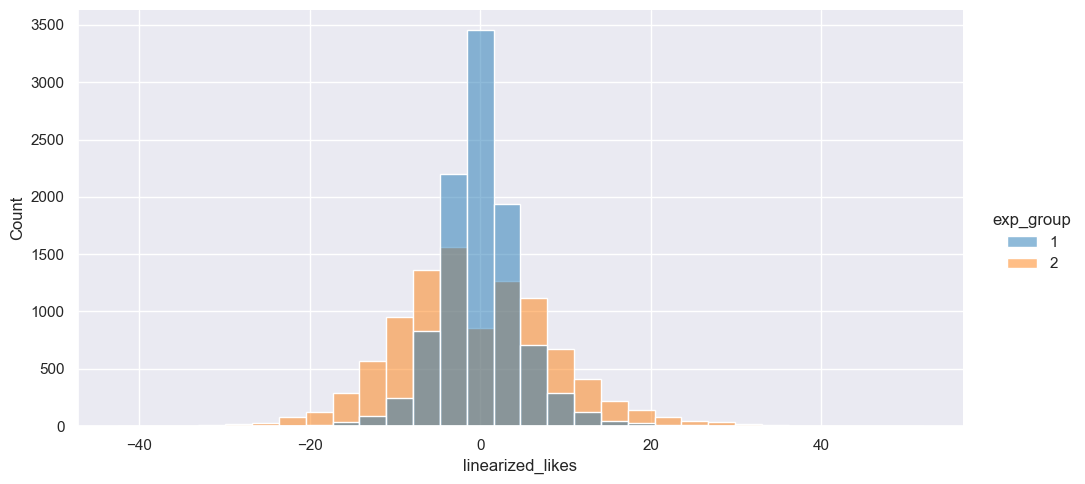

In [ ]:
sns.displot(data=df[df['exp_group'].isin([1,2])], x='linearized_likes', hue='exp_group', kde=False,palette='tab10',bins=30, height=5, aspect=2)

In [ ]:
print(ttest_ind(df[df['exp_group']==1].linearized_likes, df[df['exp_group']==2].linearized_likes, equal_var=False))

Ttest_indResult(statistic=5.936377101934481, pvalue=2.9805064038667945e-09)


In [ ]:
print(stats.mannwhitneyu(df[df['exp_group']==1].ctr, df[df['exp_group']==2].linearized_likes))

MannwhitneyuResult(statistic=55176474.0, pvalue=7.416111998094547e-45)


On linerized CTR, Ttest and Mannwhitney test are showing, that there is a statistically significant difference in CTR between experimental groups 1 and 2. 
The sensitivity of the tests has increased, allowing differences to be detected when performing t-tests.  